In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import copy

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths
from utils import prf_utils


In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False, return_filename=False) \
       for ss in subjects]

In [3]:
# pull out the pRF params

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = np.round(sigma * screen_eccen_deg, 2)
angle_fwrf = np.round(angle_fwrf,2)
eccen_fwrf = np.round(eccen_fwrf,2)

x_fwrf, y_fwrf = x*screen_eccen_deg, y*screen_eccen_deg

In [4]:
# define linearly spaced bins for each parameters, use for histograms
size_bins = np.linspace(0.10, 8.5, 10)
eccen_bins = np.linspace(0, 7.1, 10)
x_bins = np.linspace(-7.1, 7.1, 10); 
y_bins = np.linspace(-7.1, 7.1, 10)

In [5]:
# non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [6]:
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff


#### Creating histograms, grouping voxels across multiple ROIs (early/place/face)

In [19]:
roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

hist_values = [np.zeros((n_roi_groups, len(bins)-1)) for bins in [size_bins, eccen_bins, y_bins, x_bins]]
n_par_types = 4;

bin_centers_eachpar = [[] for par in range(n_par_types)]

median_eachpar = np.zeros((n_roi_groups, n_par_types))
mean_eachpar = np.zeros((n_roi_groups, n_par_types))

for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    # bi = -1
    for bi, [bins, par_vals] in enumerate(zip([size_bins, eccen_bins, y_bins, x_bins], \
                                              [size_fwrf, eccen_fwrf, y_fwrf, x_fwrf])):
        # bi+=1
        counts, bin_edges = np.histogram(par_vals[inds], bins=bins)
        assert(np.sum(counts)==np.sum(inds))
               
        # convert to proportion
        hist_values[bi][rr,:] = counts/np.sum(counts)
        
        bin_width = (bin_edges[1]-bin_edges[0])
        bin_centers = bins[0:-1]+bin_width/2
        
        bin_centers_eachpar[bi] = bin_centers
        
        median_eachpar[rr,bi] = np.median(par_vals[inds])
        mean_eachpar[rr,bi] = np.mean(par_vals[inds])
        

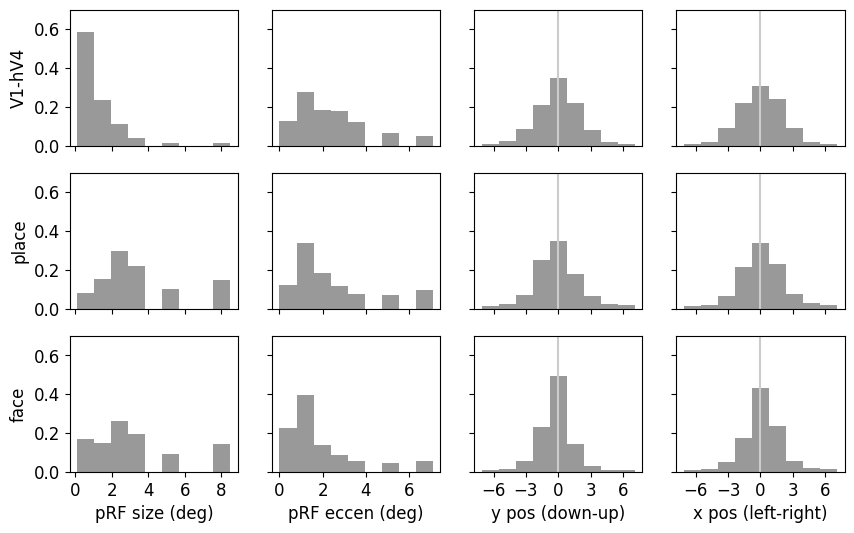

In [21]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = np.tile(np.array([[0.6, 0.6, 0.6,1]]), [n_roi_groups,1])

ylims = [0, 0.70]
yticks = [0, 0.2, 0.4, 0.6]

xticks = [[0,2,4,6,8], [0,2,4,6], [-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]]
xlims = [[0,8.5],[0,7.1],[-7.1,7.1],[-7.1,7.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

npx = n_roi_groups
# npx = n_roi_groups+1

plt.figure(figsize=(10,6));

pi=0;

for rr in range(n_roi_groups):

    for par in range(n_par_types):

        bar_centers = bin_centers_eachpar[par]

        bar_heights = hist_values[par][rr,:]
        name = roi_group_names[rr]

        pi+=1
        plt.subplot(npx,4,pi)

        bin_width = bar_centers[1] - bar_centers[0]
        plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

        if rr==(npx-1):
            plt.xlabel(par_names[par])
            plt.xticks(xticks[par])
        else:
            plt.xticks(xticks[par], labels=[])

        plt.ylim(ylims)
            
        if par==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])

        if par>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
            
        # plt.axvline(median_eachpar[rr,par], color=[0, 0.7, 0.8, 1])
        # plt.axvline(mean_eachpar[rr,par], color=[0, 0.7, 0.8, 1])
            
fn2save = os.path.join(default_paths.fig_path, 'prf_params_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

#### adding face-place difference

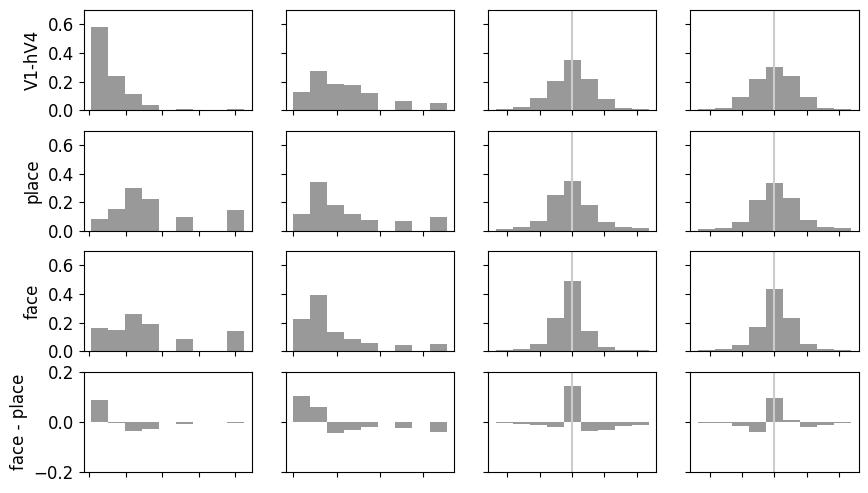

In [22]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = np.tile(np.array([[0.6, 0.6, 0.6,1]]), [n_roi_groups,1])

ylims = [0, 0.70]
yticks = [0, 0.2, 0.4, 0.6]

ylims_diff = [-0.2, 0.2]
yticks_diff = [-0.2, 0, 0.2]

xticks = [[0,2,4,6,8], [0,2,4,6], [-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]]
xlims = [[0,8.5],[0,7.1],[-7.1,7.1],[-7.1,7.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

npx = n_roi_groups+1
# npx = n_roi_groups

plt.figure(figsize=(10,6));

pi=0;

for rr in range(n_roi_groups):

    for par in range(n_par_types):

        bar_centers = bin_centers_eachpar[par]

        bar_heights = hist_values[par][rr,:]
        name = roi_group_names[rr]

        pi+=1
        plt.subplot(npx,4,pi)

        bin_width = bar_centers[1] - bar_centers[0]
        plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

        # plt.xlim(xlims[par])
        if rr==(npx-1):
            plt.xlabel(par_names[par])
            plt.xticks(xticks[par])
        else:
            plt.xticks(xticks[par], labels=[])

        plt.ylim(ylims)
            
        if par==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])

        if par>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
            
for par in range(n_par_types):

    bar_centers = bin_centers_eachpar[par]

    bar_heights = hist_values[par][2,:] - hist_values[par][1,:]
    name = '%s - %s'%(roi_group_names[2], roi_group_names[1])

    pi+=1
    plt.subplot(npx,4,pi)

    bin_width = bar_centers[1] - bar_centers[0]
    plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

    # plt.xlim(xlims[par])
    if rr==(npx-1):
        plt.xlabel(par_names[par])
        plt.xticks(xticks[par])
    else:
        plt.xticks(xticks[par], labels=[])

    plt.ylim(ylims_diff)

    if par==0:
        plt.ylabel(name)
        plt.yticks(yticks_diff)
    else:
        plt.yticks(yticks_diff,[])

    if par>1:
        plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
        
 

#### Plot each individual ROI

In [23]:
hist_values = [np.zeros((n_rois, len(bins)-1)) for bins in [size_bins, eccen_bins, y_bins, x_bins]]
n_par_types = 4;

bin_centers_eachpar = [[] for par in range(n_par_types)]

for rr in range(n_rois):
    
    inds = roi_def.get_indices(rr) & abv_thresh

    for bi, [bins, par_vals] in enumerate(zip([size_bins, eccen_bins, y_bins, x_bins], \
                                              [size_fwrf, eccen_fwrf, y_fwrf, x_fwrf])):
             
        counts, bin_edges = np.histogram(par_vals[inds], bins=bins)
        
        hist_values[bi][rr,:] = counts/np.sum(counts)
        
        bin_width = (bin_edges[1]-bin_edges[0])
        bin_centers = bins[0:-1]+bin_width/2
        
        bin_centers_eachpar[bi] = bin_centers
        

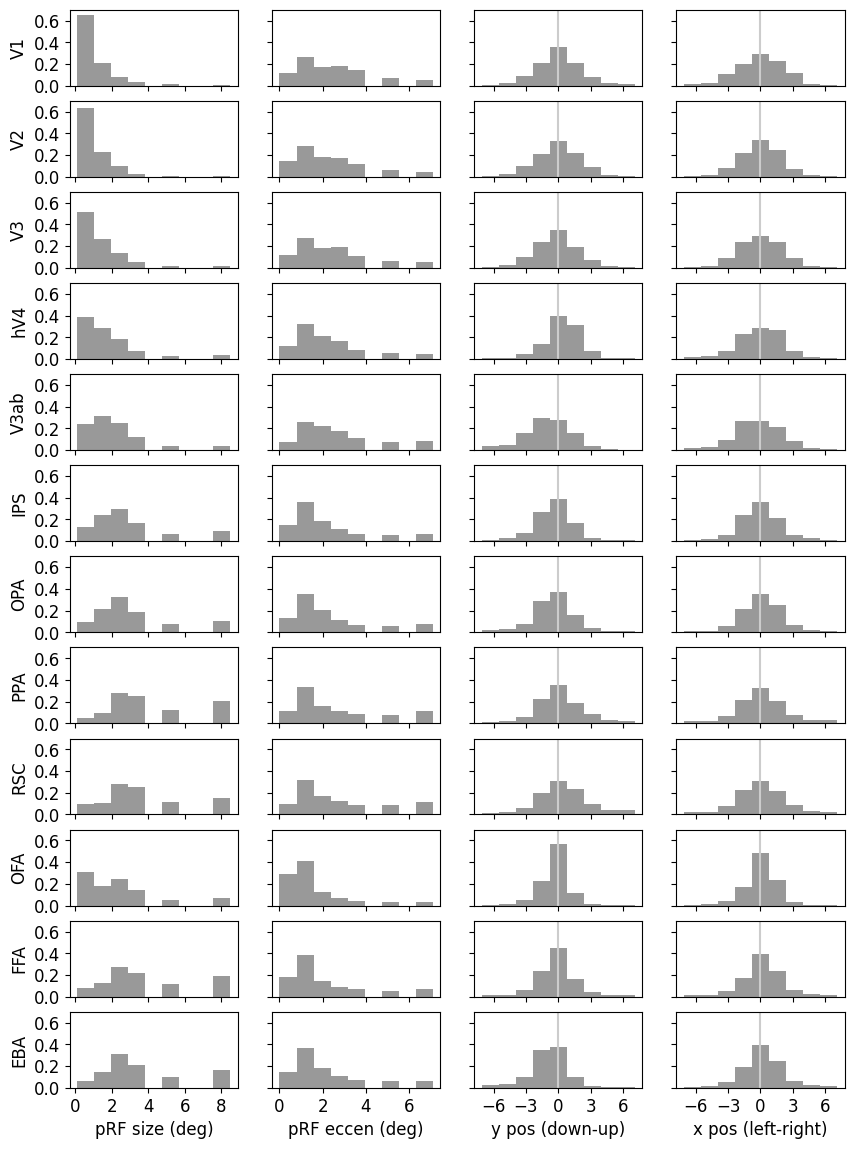

In [24]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = np.tile(np.array([[0.6, 0.6, 0.6,1]]), [n_rois,1])

ylims = [0, 0.70]
yticks = [0, 0.2, 0.4, 0.6]

ylims_diff = [-0.4, 0.4]
yticks_diff = [-0.2, 0, 0.2]

xticks = [[0,2,4,6,8], [0,2,4,6], [-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]]
xlims = [[0,8.5],[0,7.1],[-7.1,7.1],[-7.1,7.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

npx = n_rois

plt.figure(figsize=(10,14));

pi=0;

for rr in range(n_rois):

    for par in range(n_par_types):

        bar_centers = bin_centers_eachpar[par]

        bar_heights = hist_values[par][rr,:]
        name = roi_names[rr]

        pi+=1
        plt.subplot(npx,4,pi)

        bin_width = bar_centers[1] - bar_centers[0]
        plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

        # plt.xlim(xlims[par])
        if rr==(npx-1):
            plt.xlabel(par_names[par])
            plt.xticks(xticks[par])
        else:
            plt.xticks(xticks[par], labels=[])

        plt.ylim(ylims)
            
        if par==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])

        if par>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
            
            
fn2save = os.path.join(default_paths.fig_path, 'prf_params_allrois.pdf')
plt.savefig(fn2save, format='pdf')